In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn-whitegrid')


In [27]:
xl = pd.ExcelFile('20190927_HeartSurvey_edited.xlsx')
survey = xl.parse("Sheet1")
survey.head()

,Duration (in seconds),RecordedDate,ResponseId,Q2.1,Q2.2,Q2.3,Q4.2_1,Q4.3,Q5.2_1,Q5.3,...,Q69.1_2,Q69.1_3,Q69.1_4,Q69.1_5,Q69.1_6,Q69.1_7,Q69.1_8,Q69.1_9,Q69.1_10,Q69.2_1
0,10106,2019-09-11 16:40:00,R_32XStqqXgBnksiC,Physician,20-24 years,20-24 years,0,Yes,100,No,...,NaN,NaN,Number 3,Number 2,NaN,NaN,NaN,Number 4,Number 1,Highly Risk Tolerant
1,4925,2019-09-11 16:40:00,R_2bTotYExBytoNpf,Physician,0-4 years,0-4 years,9,Yes,49,No,...,NaN,NaN,NaN,Number 4,Number 2,Number 1,NaN,NaN,Number 3,Neutral
2,10386,2019-09-11 16:40:00,R_28HubDeTQcBnH6b,Physician,0-4 years,0-4 years,0,Yes,100,No,...,NaN,Number 2,NaN,Number 3,NaN,NaN,NaN,Number 4,Number 5,Neutral
3,10243,2019-09-11 16:40:00,R_3rZnt5JFNJxWU8U,Physician,5-9 years,5-9 years,10,Yes,100,No,...,NaN,Number 5,Number 4,Number 3,NaN,NaN,NaN,NaN,Number 2,Neutral
4,10723,2019-09-11 16:41:00,R_8CzCYLAwaFnUdcR,Physician,20-24 years,20-24 years,8,Yes,99,No,...,NaN,NaN,Number 3,Number 4,NaN,Number 5,NaN,NaN,Number 2,Somewhat Risk Averse


In [28]:
## Extract risk data to its own dataframe

risk = survey.iloc[:, 10:130:2].fillna(50) ## All the actual questions, risk value
risk.head()

,Q7.2_1,Q8.2_1,Q9.2_1,Q10.2_1,Q11.2_1,Q12.2_1,Q13.2_1,Q14.2_1,Q15.2_1,Q16.2_1,...,Q58.2_1,Q59.2_1,Q60.2_1,Q61.2_1,Q62.2_1,Q63.2_1,Q64.2_1,Q65.2_1,Q66.2_1,Q67.2_1
0,50.0,92,63.0,0,100.0,40.0,100,0,71,97.0,...,89,40.0,100,100,77,66.0,84,15,70.0,86.0
1,77.0,100,62.0,7,50.0,50.0,80,14,98,87.0,...,83,71.0,100,94,90,80.0,100,11,79.0,82.0
2,41.0,82,35.0,6,61.0,46.0,69,5,75,57.0,...,72,54.0,94,82,73,72.0,90,24,59.0,77.0
3,59.0,100,50.0,0,90.0,60.0,96,15,88,79.0,...,76,38.0,92,74,92,50.0,85,13,50.0,50.0
4,68.0,81,58.0,3,88.0,16.0,77,15,78,75.0,...,84,76.0,92,88,86,81.0,91,31,74.0,71.0


In [29]:
## Rename columns for risk dataframe

risk.columns = [i for i in range(60)]
risk.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,50.0,92,63.0,0,100.0,40.0,100,0,71,97.0,...,89,40.0,100,100,77,66.0,84,15,70.0,86.0
1,77.0,100,62.0,7,50.0,50.0,80,14,98,87.0,...,83,71.0,100,94,90,80.0,100,11,79.0,82.0
2,41.0,82,35.0,6,61.0,46.0,69,5,75,57.0,...,72,54.0,94,82,73,72.0,90,24,59.0,77.0
3,59.0,100,50.0,0,90.0,60.0,96,15,88,79.0,...,76,38.0,92,74,92,50.0,85,13,50.0,50.0
4,68.0,81,58.0,3,88.0,16.0,77,15,78,75.0,...,84,76.0,92,88,86,81.0,91,31,74.0,71.0


In [30]:
## Extract waitlist decision data to its own dataframe

waitlist = survey.iloc[:, 11:130:2] ## All the actual questions, risk value
waitlist.head()

,Q7.3,Q8.3,Q9.3,Q10.3,Q11.3,Q12.3,Q13.3,Q14.3,Q15.3,Q16.3,...,Q58.3,Q59.3,Q60.3,Q61.3,Q62.3,Q63.3,Q64.3,Q65.3,Q66.3,Q67.3
0,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,No,...,No,Yes,No,No,No,Yes,No,Yes,Yes,No
1,Yes,No,Yes,Yes,No,Yes,No,Yes,No,Yes,...,No,Yes,No,No,No,Yes,No,Yes,Yes,No
2,Yes,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,...,No,Yes,No,No,No,Yes,No,Yes,Yes,No
3,Yes,No,Yes,Yes,No,Yes,No,Yes,No,Yes,...,No,Yes,No,No,No,Yes,No,Yes,Yes,Yes
4,Yes,No,Yes,Yes,No,Yes,No,Yes,No,Yes,...,No,Yes,No,No,No,Yes,No,Yes,Yes,Yes


In [31]:
## Rename waitlist decision columns to match the risk columns

waitlist.columns = [i for i in range(60)]
waitlist.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,No,...,No,Yes,No,No,No,Yes,No,Yes,Yes,No
1,Yes,No,Yes,Yes,No,Yes,No,Yes,No,Yes,...,No,Yes,No,No,No,Yes,No,Yes,Yes,No
2,Yes,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,...,No,Yes,No,No,No,Yes,No,Yes,Yes,No
3,Yes,No,Yes,Yes,No,Yes,No,Yes,No,Yes,...,No,Yes,No,No,No,Yes,No,Yes,Yes,Yes
4,Yes,No,Yes,Yes,No,Yes,No,Yes,No,Yes,...,No,Yes,No,No,No,Yes,No,Yes,Yes,Yes


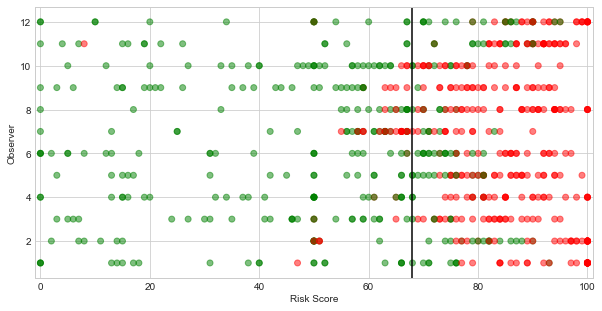

In [32]:
# All scenarios stacked into one chart, with a Mean of Means line thrown in
plt.rcParams['figure.figsize'] = [10, 5]
y = risk.index.values + 1
colors = waitlist
colors[colors == 'Yes'] = 'green'
colors[colors == 'No'] = 'red'

for question in range(60):
    x = risk[question]
    x_mean = risk[question].mean()
    plt.scatter(x, y, marker='o', color=colors[question], alpha=0.5)
plt.axvline(x=risk.mean().mean(), color='black')
plt.xlim(-1, 101)
plt.ylabel('Observer')
plt.xlabel('Risk Score')
# risk.mean().mean()
plt.savefig('plot_AllScores.jpg')

In [33]:
## Change Yes/No to green/red, for use in the graphs

waitlist[waitlist == 'Yes'] = 'green'
waitlist[waitlist == 'No'] = 'red'
waitlist.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,green,red,green,green,red,green,red,green,green,red,...,red,green,red,red,red,green,red,green,green,red
1,green,red,green,green,red,green,red,green,red,green,...,red,green,red,red,red,green,red,green,green,red
2,green,red,green,green,green,green,red,green,red,green,...,red,green,red,red,red,green,red,green,green,red
3,green,red,green,green,red,green,red,green,red,green,...,red,green,red,red,red,green,red,green,green,green
4,green,red,green,green,red,green,red,green,red,green,...,red,green,red,red,red,green,red,green,green,green


In [34]:
xl = pd.ExcelFile('Survey questions key.xlsx')
survey_key = xl.parse("Sheet1")
survey_key

,Scenario,Output Q No,SRTR Risk,Age,Diagnosis,Blood Group,BMI,PVR,Creat,Bili,Diab,LVAD,ECMO,Vent,Total No Of Risk Factors
0,1,7,15.51,0,0,0,1,0,0,0,1,1,0,0,3
1,2,8,26.40,1,0,0,1,0,1,1,0,0,0,1,5
2,3,9,7.36,0,0,0,0,0,1,0,0,0,0,0,1
3,4,10,4.01,0,0,0,0,0,0,0,0,0,0,0,0
4,5,11,3.67,0,0,0,0,1,0,0,0,0,0,0,1
5,6,12,6.56,0,0,0,0,0,0,0,0,1,0,0,1
6,7,13,15.79,0,0,0,0,1,1,0,1,0,0,1,4
7,8,14,5.31,0,0,1,0,0,0,0,0,0,0,0,1
8,9,15,16.87,1,0,0,1,0,1,0,0,0,0,0,3
9,10,16,12.96,0,0,0,0,0,1,0,0,1,0,0,2


In [35]:

srtr_risk = pd.DataFrame(survey_key["SRTR Risk"])
scaler = MinMaxScaler(feature_range=(0,100))
scaled_srtr_risk = scaler.fit_transform(srtr_risk)
scaled_srtr_risk = pd.DataFrame(scaled_srtr_risk, columns=['Risk'])
scaled_srtr_risk.head()

,Risk
0,46.304263
1,88.893234
2,14.430974
3,1.329683
4,0.000000


In [36]:
## Calculate mean score per scenario

def calculateMeanScorePerScenario(risk_score, start_scenario=1, stop_scenario=60):
    mean_score = []
    n_observers, n_scenarios = risk_score.shape
    for scenario in range(n_scenarios):
        mean_score.append(risk_score.iloc[:, scenario].mean())
    return mean_score

average_risk_per_scenario = calculateMeanScorePerScenario(risk)
average_risk_per_scenario[0]

55.083333333333336

In [37]:
## Calculate mean score per provider

def calculateMeanScorePerObserver(risk_score):
    mean_score = []
    n_observers, n_scenarios = risk_score.shape
    for observer in range(n_observers):
        mean_score.append(risk_score.iloc[observer, :].mean())
    return mean_score

average_risk_per_observer = calculateMeanScorePerObserver(risk)
average_risk_per_observer[0]

70.88333333333334

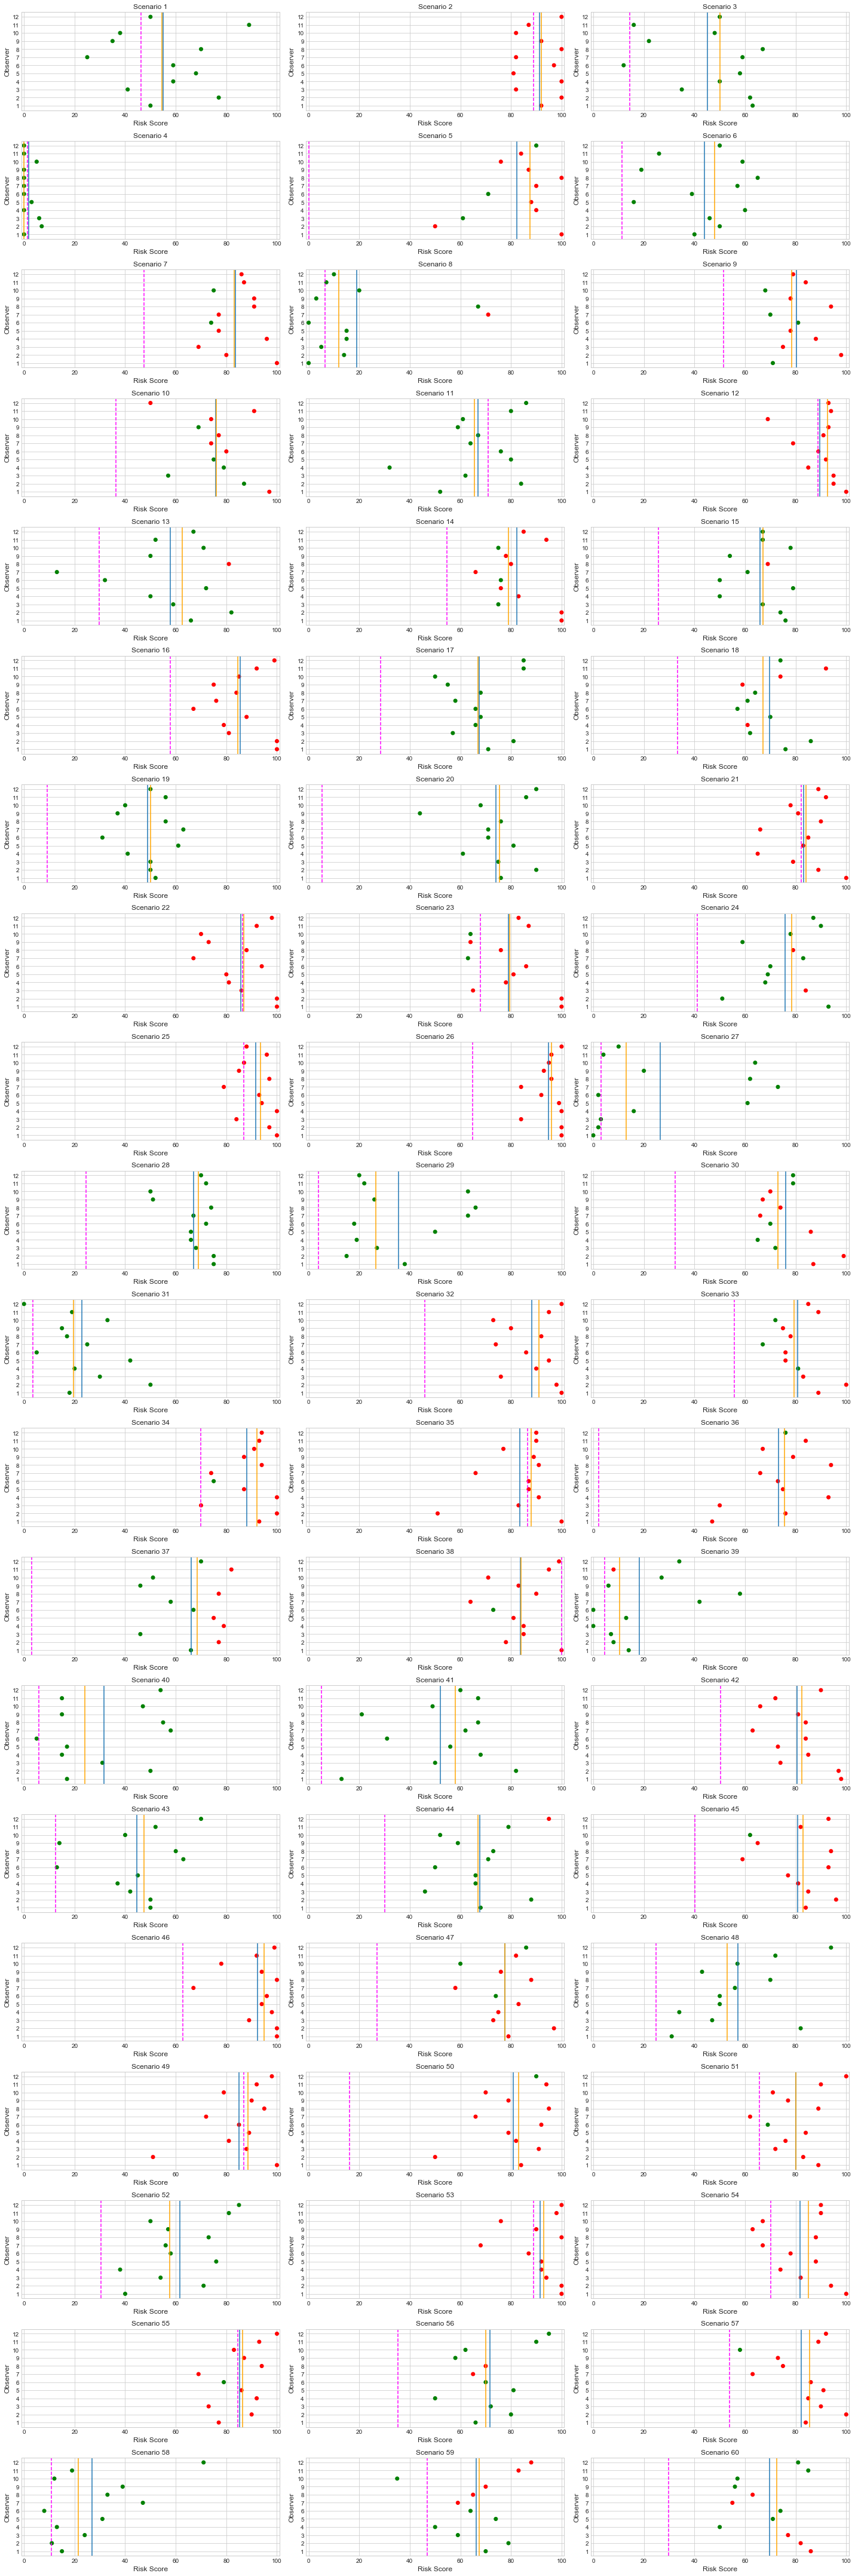

In [38]:
## Plot the results of each scenario plus their mean and median

def plotAllScenarios(risk, verdict, srtr):
    plt.rcParams['figure.figsize'] = [20, 60]
    fig, axs = plt.subplots(20, 3)
    observer = risk.index.values + 1
    colors = verdict
    colors[colors == 'Yes'] = 'green'
    colors[colors == 'No'] = 'red'
    question_number = 0
    for i in range(20):
        for j in range(3):
            axs[i, j].set_xlim([-1, 101])
            axs[i, j].scatter(risk[question_number], observer, color=colors[question_number])
            axs[i, j].axvline(x=risk[question_number].mean())
            axs[i, j].axvline(x=risk[question_number].median(), color='orange')
            axs[i, j].set_title(f'Scenario {question_number + 1}', fontsize='large')
            axs[i, j].set_ylabel('Observer', fontsize='large')
            axs[i, j].set_xlabel('Risk Score', fontsize='large')
            axs[i, j].axvline(srtr.iloc[question_number].values, color='magenta', linestyle='--')
            axs[i, j].set_yticks(risk.index.values+1)
            question_number += 1
    plt.tight_layout()
            
plotAllScenarios(risk, waitlist, scaled_srtr_risk)
plt.savefig('plot_AllScoresPerScenario.jpg')


In [39]:
risk.index.values+1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [40]:
def calculateDeviationFromMeanByObserver(risk_scores, start_scenario=1, stop_scenario=60):
    """Calculates Mean Squared Error against the overall mean for that observer"""
    mse = []
    number_of_observers = len(risk_scores)
    for observer in range(number_of_observers):
        scores = risk_scores.iloc[observer, start_scenario-1:stop_scenario-1]
        scores_mean = scores.mean()
        n = len(scores)
        mse.append((1/n)*np.sum((scores - scores_mean)**2))
        # print(f'MSE, Observer {observer + 1}:\t{mse[observer]}  (numerator: {np.sum((x-x_mean)**2)}, denominator: {len(x)})')
    return np.array(mse)
    
mse_noscore = calculateDeviationFromMeanByObserver(risk, 1, 30)
mse_withscore = calculateDeviationFromMeanByObserver(risk, 31, 60)

for i in range(len(mse_noscore)):
    print(f'Observer {i+1}:  Without score {mse_noscore[i]}, With score {mse_withscore[i]}')

Observer 1:  Without score 982.6896551724138, With score 941.8002378121284
Observer 2:  Without score 887.0273483947681, With score 630.3876337693222
Observer 3:  Without score 599.9310344827586, With score 518.3638525564803
Observer 4:  Without score 722.0975029726516, With score 790.5873959571936
Observer 5:  Without score 506.40665873959557, With score 485.9120095124852
Observer 6:  Without score 886.4827586206897, With score 854.6611177170034
Observer 7:  Without score 386.6468489892984, With score 97.26991676575506
Observer 8:  Without score 356.9726516052318, With score 376.29964328180733
Observer 9:  Without score 731.5505350772889, With score 682.3852556480381
Observer 10:  Without score 376.5588585017837, With score 317.6361474435197
Observer 11:  Without score 979.0535077288943, With score 673.0701545778835
Observer 12:  Without score 812.2116527942925, With score 483.8002378121282


In [41]:
def calculateDeviationFromSRTRByObserver(risk_scores, srtr, start_scenario=1, stop_scenario=60):
    """Calculates Mean Squared Error against each SRTR score for the observer"""
    mse = []
    number_of_observers = len(risk_scores)
    for observer in range(number_of_observers):
        scores = risk_scores.iloc[observer, start_scenario-1:stop_scenario-1]
        srtr_scores = srtr.iloc[start_scenario-1:stop_scenario-1, 0]
        scores_mean = scores.mean()
        n = len(scores)
        mse.append((1/n)*np.sum((scores - srtr_scores)**2))
        # print(f'MSE, Observer {observer + 1}:\t{mse[observer]}  (numerator: {np.sum((x-x_mean)**2)}, denominator: {len(x)})')
    return np.array(mse)
    
mse_noscore = calculateDeviationFromSRTRByObserver(risk, scaled_srtr_risk, 1, 30)
mse_withscore = calculateDeviationFromSRTRByObserver(risk, scaled_srtr_risk, 31, 60)

for i in range(len(mse_noscore)):
    print(f'Observer {i+1}:  Without score {mse_noscore[i]}, With score {mse_withscore[i]}')

Observer 1:  Without score 1655.7849835056281, With score 1078.426530521952
Observer 2:  Without score 1448.6788650748163, With score 2005.7234301753708
Observer 3:  Without score 803.7917802636825, With score 891.5076735640406
Observer 4:  Without score 1114.9745779927023, With score 1252.0458176714942
Observer 5:  Without score 1383.3460936427769, With score 1328.199284152958
Observer 6:  Without score 755.8755799750901, With score 1035.1482275537644
Observer 7:  Without score 1499.0431659122742, With score 1061.1435480397868
Observer 8:  Without score 1837.0716340794418, With score 1843.8631682844161
Observer 9:  Without score 693.7337650788618, With score 811.0892279178767
Observer 10:  Without score 1221.2958192101848, With score 780.6830811672394
Observer 11:  Without score 1433.1201418943651, With score 1685.0290820033485
Observer 12:  Without score 1350.839263170645, With score 2166.9023305570145


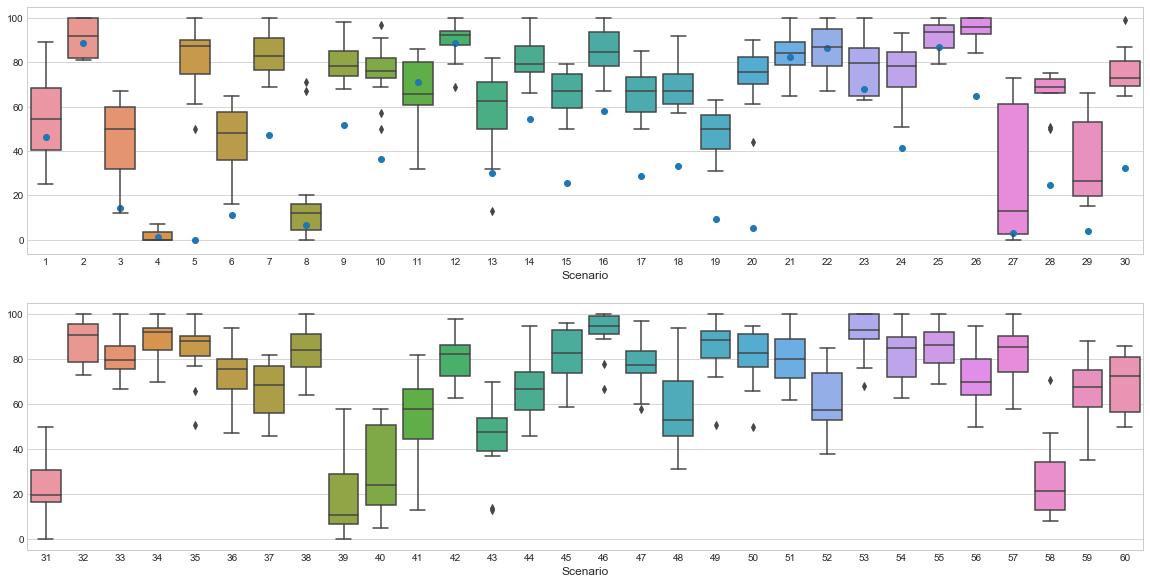

In [67]:
## Box plot
#  Shows median, 1.5 interquartile range, and range of scores for each scenario

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(data=risk.iloc[:, 0:30])
ax_1.set_xticklabels(risk.iloc[:, 0:30].columns.values+1)
ax_1.set_xlabel('Scenario', fontsize='large')
ax_1 = plt.scatter(np.arange(30), scaled_srtr_risk[0:30])

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(data=risk.iloc[:, 30:60])
ax_2.set_xticklabels(risk.iloc[:, 30:60].columns.values+1)
ax_2.set_xlabel('Scenario', fontsize='large');

plt.savefig('plot_BoxPerScenario.jpg')

In [65]:
np.arange(30)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

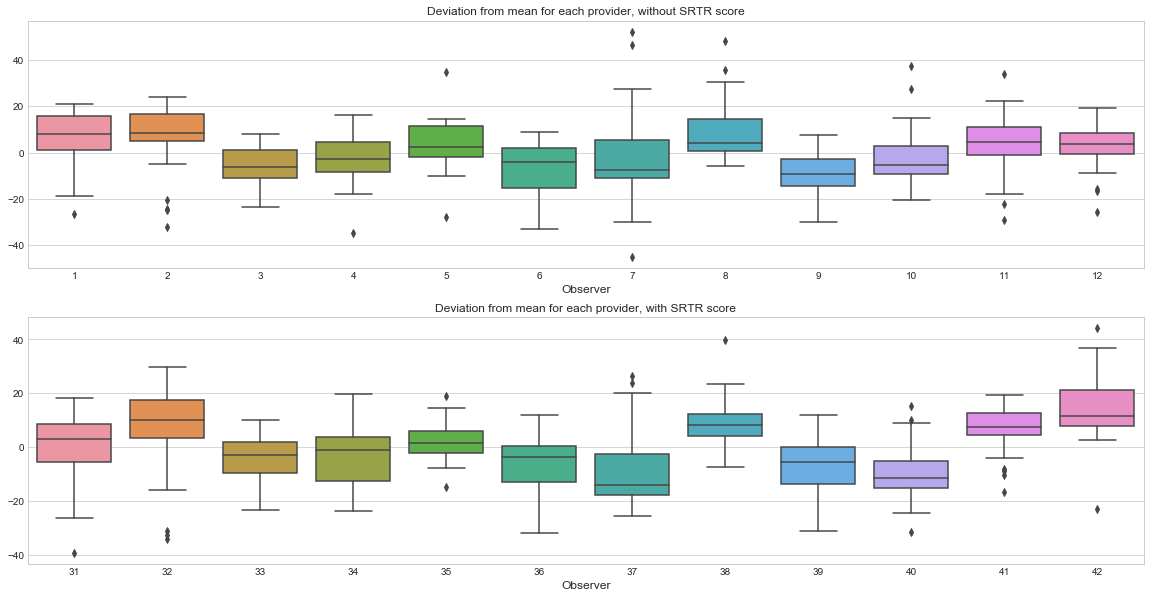

In [43]:
risk.iloc[:, 0:30] - risk.iloc[:, 0:30].mean()
## Box plot
#  Shows median, 1.5 interquartile range, and range of scores for each scenario

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(data=(risk.iloc[:, 0:30] - risk.iloc[:, 0:30].mean()).T)
ax_1.set_xticklabels(risk.iloc[:, 0:30].columns.values+1)
ax_1.set_xlabel('Observer', fontsize='large')
ax_1.title.set_text('Deviation from mean for each provider, without SRTR score')

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(data=(risk.iloc[:, 30:60] - risk.iloc[:, 30:60].mean()).T)
ax_2.set_xticklabels(risk.iloc[:, 30:60].columns.values+1)
ax_2.set_xlabel('Observer', fontsize='large')
ax_2.title.set_text('Deviation from mean for each provider, with SRTR score');

#plt.savefig('plot2.jpg')

In [44]:
risk.iloc[:, 0:30] - risk.iloc[:, 0:30].mean()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-5.083333,0.75,17.833333,-1.75,17.75,-3.916667,16.416667,-18.916667,-9.333333,21.166667,...,16.916667,14.25,21.083333,17.083333,8.333333,5.083333,-26.416667,7.833333,2.416667,10.833333
1,21.916667,8.75,16.833333,5.25,-32.25,6.083333,-3.583333,-4.916667,17.666667,11.166667,...,5.916667,14.25,21.083333,-24.916667,5.333333,5.083333,-24.416667,7.833333,-20.583333,22.833333
2,-14.083333,-9.25,-10.166667,4.25,-21.25,2.083333,-14.583333,-13.916667,-5.333333,-18.833333,...,-4.083333,0.25,-13.916667,8.083333,-7.666667,-10.916667,-23.416667,0.833333,-8.583333,-4.166667
3,3.916667,8.75,4.833333,-1.75,7.75,16.083333,12.416667,-3.916667,7.666667,3.166667,...,-18.083333,-4.75,-0.916667,-7.916667,8.333333,5.083333,-10.416667,-1.166667,-16.583333,-11.166667
4,12.916667,-10.25,12.833333,1.25,5.75,-27.916667,-6.583333,-3.916667,-2.333333,-0.833333,...,-0.083333,-5.75,2.083333,-6.916667,2.333333,4.083333,34.583333,-1.166667,14.416667,9.833333
5,3.916667,5.75,-33.166667,-1.75,-11.25,-4.916667,-9.583333,-18.916667,0.666667,4.166667,...,1.916667,8.25,7.083333,-5.916667,1.333333,-2.916667,-24.416667,4.833333,-17.583333,-6.166667
6,-30.083333,-9.25,13.833333,-1.75,7.75,13.083333,-6.583333,52.083333,-10.333333,-1.833333,...,-17.083333,-18.75,-15.916667,7.083333,-12.666667,-10.916667,46.583333,-0.166667,27.416667,-10.166667
7,14.916667,8.75,21.833333,-1.75,17.75,21.083333,7.416667,48.083333,13.666667,1.166667,...,6.916667,2.25,-2.916667,3.083333,5.333333,1.083333,35.583333,6.833333,30.416667,-2.166667
8,-20.083333,0.75,-23.166667,-1.75,4.75,-24.916667,7.416667,-15.916667,-2.333333,-6.833333,...,-2.083333,-12.75,-14.916667,-16.916667,-6.666667,-1.916667,-6.416667,-16.166667,-9.583333,-9.166667
9,-17.083333,-9.25,2.833333,3.25,-6.25,15.083333,-8.583333,1.083333,-12.333333,-1.833333,...,-5.083333,-15.75,-14.916667,2.083333,-4.666667,0.083333,37.583333,-17.166667,27.416667,-6.166667


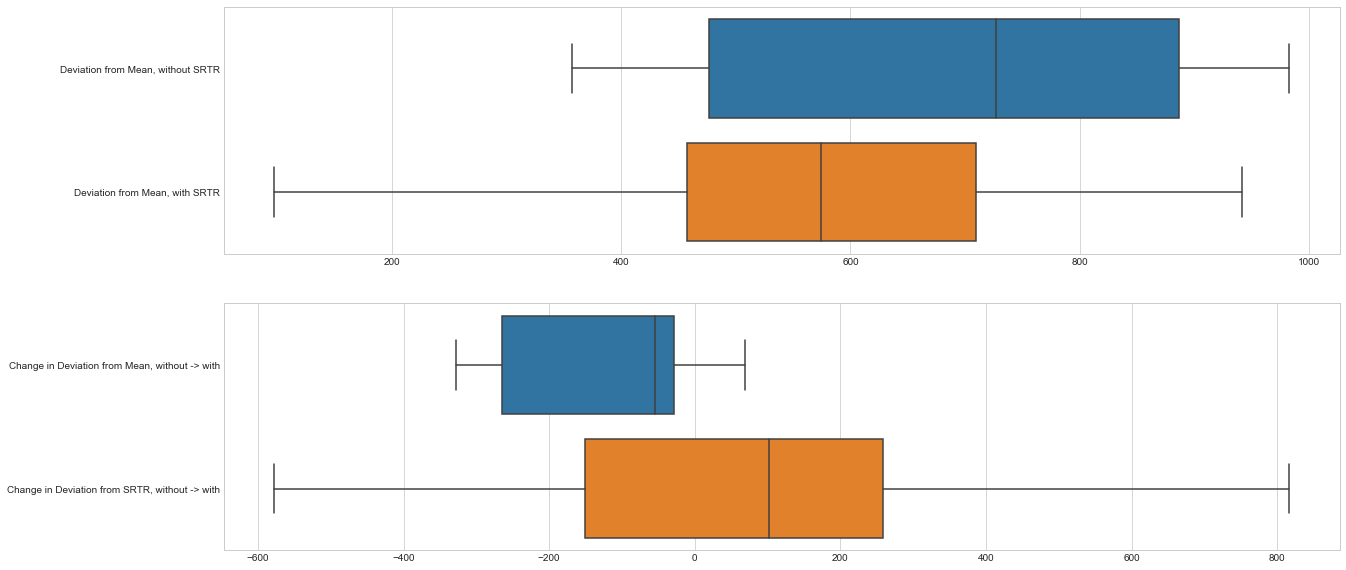

In [45]:
## Plot "mean squared error" across providers, split by Mean/SRTR Score, and by With/Without SRTR Score

mse_mean_blind = calculateDeviationFromMeanByObserver(risk, 1, 30)
mse_mean = calculateDeviationFromMeanByObserver(risk, 31, 60)
mse_srtr_blind = calculateDeviationFromSRTRByObserver(risk, scaled_srtr_risk, 1, 30)
mse_srtr = calculateDeviationFromSRTRByObserver(risk, scaled_srtr_risk, 31, 60)

deviations = pd.DataFrame(
               np.array([mse_mean_blind, mse_mean]),
               index=['Deviation from Mean, without SRTR', 'Deviation from Mean, with SRTR'])

changes = pd.DataFrame(
               np.array([mse_mean - mse_mean_blind, mse_srtr - mse_srtr_blind]),
               index=['Change in Deviation from Mean, without -> with', 'Change in Deviation from SRTR, without -> with'])

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(data=deviations.T, orient='h')


plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(data=changes.T, orient='h')


plt.savefig('plot_BoxDeviations.jpg')

In [46]:
observer_class = pd.DataFrame(survey.iloc[:, 3:5])
observer_class.columns = ['Observer Type', 'Experience']
observer_class



,Observer Type,Experience
0,Physician,20-24 years
1,Physician,0-4 years
2,Physician,0-4 years
3,Physician,5-9 years
4,Physician,20-24 years
5,Physician,5-9 years
6,Physician,5-9 years
7,Physician,0-4 years
8,Physician,25-29 years
9,Physician,5-9 years


Text(0, 0.5, 'Observer Risk Score')

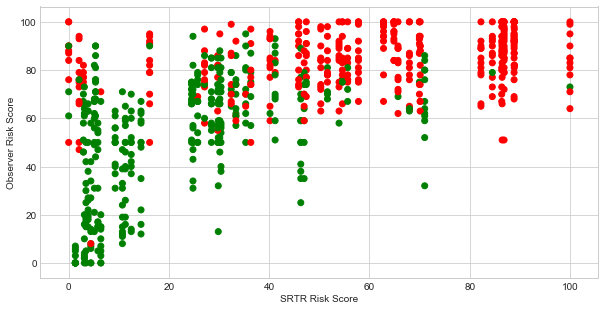

In [49]:
test_risk = risk
risk.iloc[0, :]

plt.figure(figsize=(10, 5))
for i in range(12):
    plt.scatter(scaled_srtr_risk, risk.iloc[i, :], color=colors.iloc[i, :])
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')